# Google - Fast or Slow? - Detailed EDA

## About this Competition
Machine learning compilers play an important role in translating ML programs (high-level) into the optimized code (low-level) which can be executed on the specific hardware. In this competition, tensor computational graphs (represented as **H**igh **L**evel **O**prerations (**HLO**)), their configurations and the corresponding execution times are given. The competitors are challenged to predict the **runtime of each graph-configuration pair** (*i.e.,* the execution time of the graph when compiled with the specific configuration). Actually, it can be formulated as a **ranking problem**, and our goal is to **rank configurations of a given graph**.

## About this Notebook
In this kernel, I will go through the provided raw data, trying to clarify confusion in my mind when I first step into this competition. Also, a naive baseline model is implemented to illustrate how the evaluation metric works.

<a id="toc"></a>
## Table of Contents
* [1. Data Appearance](#data_appearance)
* [2. ML Compiler Optimizations](#ml_optim)
    * *[Graph-Level Optimizations](#graph_lv)*
    * *[Kernel-Level Optimizations](#kernel_lv)*
* [3. Basic Graph Statistics](#graph_stats)
    * *[layout-nlp-default](#lnd)*
    * *[layout-nlp-random](#lnr)*
    * *[layout-xla-default](#lnd)*
    * *[layout-xla-random](#lnr)*
    * *[tile-xla](#tx)*
* [4. Our Target - Runtime](#runtime)
* More analysis is coming soon...
* [Reference](#ref)

## Import Packages

In [1]:
import os
import random
import warnings
from collections import defaultdict
from pathlib import Path
from tqdm.notebook import tqdm
from typing import Any, Dict, List, Optional, Union, Tuple

import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as img
import seaborn as sns
import plotly.graph_objects as go
from matplotlib.axes import Axes
from scipy.stats import mode, skew, kurtosis
from seaborn import JointGrid

# Configuration
warnings.simplefilter('ignore')
sns.set_style("darkgrid")
colors = sns.color_palette('Set2')
random.seed(42)

## Define Paths, Metadata and Utilities

In [2]:
# Paths
DATA_ROOT = Path("/kaggle/input/predict-ai-model-runtime/npz_all/npz")

# Metadata
# ==Data==
# Compiler optimization
OPTIM = ["layout", "tile"]
# Source
SRC = ["xla", "nlp"]
# Search strategy
SEARCH = ["default", "random"]
# Dataset split
SPLIT = ["train", "valid", "test"]
# Collection
COLL = [
    "layout-nlp-default",
    "layout-nlp-random",
    "layout-xla-default",
    "layout-xla-random",
    "tile-xla"
]

In [3]:
class DataChecker(object):
    """Basic data checker.
    
    Parameters:
        optim: compiler optimization, the choices are as follows:
            {"layout", "tile"}
    """

    CHECK_ITEMS: List[str] = ["col1_deprecated", "op_align", "n_cfg_nodes"]
    
    def __init__(self, optim: str) -> None:
        self.optim = optim

        # Optimization-specific setup
        self._optim_root = DATA_ROOT/optim
        self._src = SRC if optim == "layout" else ["xla"]
        self._search = SEARCH if optim == "layout" else [""]
        
    def check(self) -> Dict[str, List[str]]:
        """Run basic data checking.
        
        Return:
            npz_illeg: .npz files failing specific check items
        """
        npz_illeg = defaultdict(list)
        for src in self._src:
            for search in self._search:
                for split in SPLIT:
                    data_dir = self._optim_root/src/search/split
        
                    print(f"Check {data_dir}...")
                    for file in os.listdir(data_dir):
                        if not file.endswith(".npz"): continue
                        
                        data_file = str(data_dir/file)
                        npz_tmp = dict(np.load(data_file))
                        if not self._check_col1_deprecated(npz_tmp["node_feat"]):
                            npz_illeg["col1_deprecated"].append(data_file)
                        if not self._check_op_align(npz_tmp["node_feat"], npz_tmp["node_opcode"]):
                            npz_illeg["op_align"].append(data_file)
                        if (self.optim == "layout"
                            and not self._check_n_cfg_nodes(npz_tmp["node_feat"], npz_tmp["node_config_ids"])):
                            npz_illeg["n_cfg_nodes"].append(data_file)

        return npz_illeg

    def _check_col1_deprecated(self, node_feat: np.ndarray) -> bool:
        """Check whether column 1 of node_feat is deprecated for all files.
        
        Parameters:
            node_feat: node feature array

        Return:
            pass_check: if True, the checking is passed
        """
        col1_deprecated = np.all(node_feat[:, 1] == 0)
        pass_check = True if col1_deprecated else False

        return pass_check

    def _check_op_align(self, node_feat: np.ndarray, node_opcode: np.ndarray) -> bool:
        """Check whether each node has its own op-code.
        
        Parameters:
            node_feat: node feature array
            node_opcode: node op-codes
    
        Return:
            pass_check: if True, the checking is passed
        """
        op_align = len(node_opcode) == len(node_feat)
        pass_check = True if op_align else False
    
        return pass_check

    def _check_n_cfg_nodes(self, node_feat: np.ndarray, node_config_id: np.ndarray) -> bool:
        """Check whether the number of configurable nodes is always less
        than the total number of nodes.
    
        Check if `nc` <= `n`.
    
        Parameters:
            node_feat: node feature array
            node_config_id: configurable node identifier
    
        Return:
            pass_check: if True, the checking is passed
        """
        n_cfg_nodes = len(node_config_id) <= len(node_feat)
        pass_check = True if n_cfg_nodes else False
    
        return pass_check
    
    
class SeabornFig2Grid():
    """See https://stackoverflow.com/questions/35042255/."""

    def __init__(self, seaborngrid, fig, subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

In [4]:
def _get_coll_root(coll: str) -> Path:
    """Parse the collection and return the corresponding data root.
    
    Parameters:
        coll: collection

    Return
        data_root: data root of the collection
    """
    coll_terms = coll.split("-")
    if len(coll_terms) == 3:
        optim, src, search = coll_terms
        data_root = DATA_ROOT/f"{optim}/{src}/{search}"
    else:
        optim, src = coll_terms
        data_root = DATA_ROOT/f"{optim}/{src}"

    return data_root


def _summarize(
    df: pd.DataFrame,
    file_name: Optional[str] = None,
    n_rows_to_display: Optional[int] = 5,
) -> None:
    """Summarize DataFrame.

    Parameters:
        df: input data
        file_name: name of the input file
        n_rows_to_display: number of rows to display

    Return:
        None
    """
    file_name = "Data" if file_name is None else file_name

    # Derive NaN ratio for each column
    nan_ratio = pd.isna(df).sum() / len(df) * 100
    nan_ratio.sort_values(ascending=False, inplace=True)
    nan_ratio = nan_ratio.to_frame(name="NaN Ratio").T

    # Derive zero ratio for each column
    zero_ratio = (df == 0).sum() / len(df) * 100
    zero_ratio.sort_values(ascending=False, inplace=True)
    zero_ratio = zero_ratio.to_frame(name="Zero Ratio").T

    # Print out summarized information
    print(f"=====Summary of {file_name}=====")
    display(df.head(n_rows_to_display))
    print(f"Shape: {df.shape}")
    print("NaN ratio:")
    display(nan_ratio)
    print("Zero ratio:")
    display(zero_ratio)


def _plot_univar_dist(
    data: Union[pd.Series, np.ndarray], feature: str, bins: int = 250, ax: Optional[Axes] = None
) -> None:
    """Plot univariate distribution.

    Parameters:
        data: univariate data to plot
        feature: feature name of the data
        bins: number of bins
        ax: user-specified axes

    Return:
        None
    """
    if isinstance(data, np.ndarray):
        data = pd.Series(data)

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 4))
    sns.histplot(data=data, bins=bins, kde=True, palette=colors, ax=ax)
    ax.axvline(x=data.mean(), color="orange", linestyle="dotted", linewidth=1.5, label="Mean")
    ax.axvline(
        x=data.median(),
        color="green",
        linestyle="dotted",
        linewidth=1.5,
        label="Median",
    )
    ax.axvline(
        x=data.mode().values[0],
        color="red",
        linestyle="dotted",
        linewidth=1.5,
        label="Mode",
    )
    ax.set_title(
        f"{feature.upper()} Distibution\n"
        f"Min {round(data.min(), 2)} | "
        f"Max {round(data.max(), 2)} | "
        f"Skewness {round(data.skew(), 2)} | "
        f"Kurtosis {round(data.kurtosis(), 2)}"
    )
    ax.set_xlabel(f"{feature}")
    ax.set_ylabel("Bin Count")
    ax.legend()
    if ax is None:
        plt.show()
        

def _plot_bivar(
    data: Union[pd.Series, np.ndarray],
    features: Optional[List[str]] = ["0", "1"],
) -> Tuple[JointGrid, str]:
    """Plot bivariate distribution with regression line fitted.

    Parameters:
        data: bivariate data to plot
        features: list of feature names

    Return:
        jg: seaborn JointGrid
        title: figure title
    """
    if isinstance(data, np.ndarray):
        data = pd.DataFrame(data)
    f1, f2 = features[0], features[1]
    corr = data[[f1, f2]].corr().iloc[0, 1]

    title = f"{f1} versus {f2}, Corr={corr:.2}"
    jg = sns.jointplot(
        x=data[f1],
        y=data[f2],
        kind="reg",
        height=6,
        marginal_ticks=True,
        joint_kws={"line_kws": {"color": "orange"}},
    )
    jg.ax_joint.set_xlabel(f1)
    jg.ax_joint.set_ylabel(f2)
    
    return jg, title

<a id="data_appearance"></a>
## 1. Data Appearance
[**<span style="color:#FEF1FE; background-color:#535d70;border-radius: 5px; padding: 2px">Go to Table of Content</span>**](#toc)

At first, I find it hard to understand how the raw data is structured. Hence, I read the amazing [paper](https://arxiv.org/abs/2308.13490) provided by the host, which clearly explains how the data is generated and arranged.

In short, the hierarchy is defined as *optimization-source-search-split*. That is, collections of data differ in terms of:
1. *optimization* - The compiler optimization
    * `layout`: The tensor computational graph is the input graph to the **layoyt assignment pass**.
    * `tile`: The fused subgraph (**kernel**) will goes through **tile size selection**.
2. *source* - The source of graphs (graph collection)<br>
There are two sources from which the computational graphs are collected:
    * `xla`: The combination of the XLA regression benchmark.
    * `nlp`: A variety of BERT for training and inference.
3. *search* - The search strategy (configuration generation)<br>
The XLA autotuner is used to generate the configurations, and there are two strategies to explore the search space:
    * `default`: Explore the search space using a **genetic algorithm** starting from the default configuration.
    * `random`: Pick random candidates in the search space.
4. *split* - The dataset split (*i.e.,* `train`, `valid`, and `test`)
  
With the information above, let's take a look at the data folder structure. Some observations are summarized as follows:
* `tile` optimization contains graphs only from `xla` source.
* There's only one search strategy for `tile` optimization (at the level of the **fused subgraph**).
    * **Graph-level** optimization is run beforehand to output a collection of kernels.
    * Configurations are generated by **enumerating** all possible tile sizes for the kernel in a random order.    

In [5]:
!tree -d /kaggle/input/predict-ai-model-runtime/npz_all/npz

/kaggle/input/predict-ai-model-runtime/npz_all/npz
├── layout
│   ├── nlp
│   │   ├── default
│   │   │   ├── test
│   │   │   ├── train
│   │   │   └── valid
│   │   └── random
│   │       ├── test
│   │       ├── train
│   │       └── valid
│   └── xla
│       ├── default
│       │   ├── test
│       │   ├── train
│       │   └── valid
│       └── random
│           ├── test
│           ├── train
│           └── valid
└── tile
    └── xla
        ├── test
        ├── train
        └── valid

24 directories


<a id="ml_optim"></a>
## 2. ML Compiler Optimizations
[**<span style="color:#FEF1FE; background-color:#535d70;border-radius: 5px; padding: 2px">Go to Table of Content</span>**](#toc)

There are two types of optimizations commonly used in ML compilers, namely **graph-level** and **kernel-level** optimizations. Let's explore each of them with the provided data.

<a id="graph_lv"></a>
### *Graph-Level Optimizations*
[**<span style="color:#FEF1FE; background-color:#535d70;border-radius: 5px; padding: 2px">Go to Table of Content</span>**](#toc)

[![Screenshot-2023-09-03-at-15-47-46-Google.png](https://i.postimg.cc/x1y5Bj0C/Screenshot-2023-09-03-at-15-47-46-Google.png)](https://postimg.cc/21ynZDLR)
> Graph-level optimizations require the entire program graph to make decisions.

At this level, the input of the optimization processes is **the entire computational graph** and the output are a collection of **fused subgraphs (kernels)**. In this comptition, **layout assignment pass** is selected as the focus.

> *Layout* configurations control how tensors are laid out in the physical memory, by specifying the dimension order of each input and output of an operation node.

After peeking a `layout` example, we can see that each `.npz` file stores many fields to be explored further.

In [6]:
layout_demo = dict(np.load(DATA_ROOT/"layout/nlp/default/train/albert_en_base_batch_size_16_test.npz"))
for k, v in layout_demo.items():
    print(f"{k:<16}", f"| Type: {type(v)} | Dtype: {str(v.dtype):<8} | Shape {v.shape}")

node_feat        | Type: <class 'numpy.ndarray'> | Dtype: float32  | Shape (1696, 140)
node_opcode      | Type: <class 'numpy.ndarray'> | Dtype: uint8    | Shape (1696,)
edge_index       | Type: <class 'numpy.ndarray'> | Dtype: int64    | Shape (2697, 2)
node_config_feat | Type: <class 'numpy.ndarray'> | Dtype: float32  | Shape (100040, 121, 18)
node_config_ids  | Type: <class 'numpy.ndarray'> | Dtype: int64    | Shape (121,)
config_runtime   | Type: <class 'numpy.ndarray'> | Dtype: int64    | Shape (100040,)
node_splits      | Type: <class 'numpy.ndarray'> | Dtype: int64    | Shape (1, 2)


Before stepping further, let's define some commonly used notations as follows:
* `n`: number of nodes (*i.e.,* tensor operations) in the graph.
* `m`: number of edges (*i.e.,* tensor flows) in the graph.
* `c`: number of differenct configurations for the specific graph.
* `nc`: number of **configurable** nodes in the graph, must be less than or equal to `n`.

####  a. `node_feat`
`node_feat` is an `(n, 140)` feature array, in which the nodes are ordered **topologically**. Each column has its own meaning, which can be found in the [data tab](https://www.kaggle.com/competitions/predict-ai-model-runtime/data). The source code used to extract feature can be found [here](https://github.com/google-research-datasets/tpu_graphs/blob/main/tpu_graphs/process_data/xla/featurizers.h#L542).

In [7]:
n = layout_demo["node_feat"].shape[0]
print(f"There are {n} nodes in this demo graph.")

There are 1696 nodes in this demo graph.


Before proceeding to the next field, let's do some basic data checkings, including:
1. Whether column 1 of `node_feat` is deprecated for all files.
    * As described in the **Node Features** section of [data tab](https://www.kaggle.com/competitions/predict-ai-model-runtime/data).
2. Whether each node has its own op-code.
    * Because each node represents a tensor operation, one node should map to one of the op-codes.
3. Whether the number of configurable nodes is always **less than or equal to** the total number of nodes.
    * As configurable node set is the subset of the entire node set, we can expect `nc <= n`.

In [8]:
# data_checker_layout = DataChecker("layout")
# npz_illeg_layout = data_checker_layout.check()

Because column 1, `element_size_in_bits`, is deprecated for all layouts, we can safely drop this column.

In [9]:
# layout_with_nonzero_col1 = npz_illeg_layout["col1_deprecated"]
# print(f"There are {len(layout_with_nonzero_col1)} layouts whose column 1 of node_feat has non-zeros.")

#### b. `node_opcode`
`node_opcode` is an `(n, )` array, whose entries represent **op-codes** of the corresponding nodes. The mapping of op-codes and instructions can be found [here](https://github.com/google-research-datasets/tpu_graphs/blob/main/tpu_graphs/process_data/xla/hlo_opcode.h#L94).

All layouts have perfect op-code mapping.

In [10]:
# layout_with_unaligned_ops = npz_illeg_layout["op_align"]
# print(f"There are {len(layout_with_unaligned_ops)} layouts with unaligned op-codes.")

#### c. `edge_index`
`edge_index` is an `(m, 2)` array, each row of which represents a directed edge `[u, v]` pointing from node `u` to `v`.

<div class="alert alert-block alert-warning">
    <h5>As described in the <a href="https://www.kaggle.com/competitions/predict-ai-model-runtime/data">data tab</a>, point <code>u</code> consumes the output of <code>v</code>. But, I think the opposite is true, isn't it?</h5>
</div>
<div class="alert alert-block alert-danger">
    <h5>The competition host has clarified the issue in <a href="https://www.kaggle.com/competitions/predict-ai-model-runtime/discussion/436786">this forum</a>. Also, the description about <code>edge_index</code> in the data tab has been modified.</h5>
</div>

#### d. `node_config_ids`
> The layout configuration of a graph is a collection of per-node layout decisions on configurable
nodes (*i.e.,* convolution and reshape).

`node_config_ids` is an `(nc, )` array, whose entries represent the indices of **configurable** nodes.

All layouts have reasonable number of configurable nodes.

In [11]:
# layout_with_more_cfg_nodes = npz_illeg_layout["n_cfg_nodes"]
# print(f"There are {len(layout_with_more_cfg_nodes)} layouts with more configurable nodes than total.")

#### e. `node_config_feat`
`node_config_feat` is an `(c, nc, 18)` configuration feature array. For an entry `[j, k]`, it represents the configuration feature vector of the configurable node `layout_tmp["node_config_ids"][k]` for the `j`-th compilation run. Each feature field has its own meaning, which can be found in the [data tab](https://www.kaggle.com/competitions/predict-ai-model-runtime/data).

Following is a quick illustration of the relationship between `config`-related fields. Let's take `j == 0` and `k == 2`.

In [12]:
c = layout_demo["node_config_feat"].shape[0]
j, k = 0, 2
node_config_id = layout_demo["node_config_ids"][k]
node_config_feat_demo = layout_demo["node_config_feat"][j][k]

print(f"There are {c} different configurations for this graph.")
print(f"The node configuration feature of the configurable node {node_config_id} in the {j}-th compilation run is:")
print(node_config_feat_demo)

There are 100040 different configurations for this graph.
The node configuration feature of the configurable node 405 in the 0-th compilation run is:
[ 2.  1.  0. -1. -1. -1.  1.  0. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


#### f. `config_runtime`
`config_runtime` is an `(c, )` target array, where the `j`-th entry represents the runtime of the `j`-th compilation run.

This field can be seen as the target of the regression task if you want to predict the runtime directly. Following shows the distribution of `config_runtime` of the demo example. As can be observed, there seems to exist multiple modals in different regions in `default` search strategy. As stated in the paper,

>  The default collection tends to contain configurations that are not too different from the default, and have similar execution times.

As for `random`, the runtimes seem to spread out, and don't show the clustering effect.

>  The random collection includes very different configurations with very different execution times.

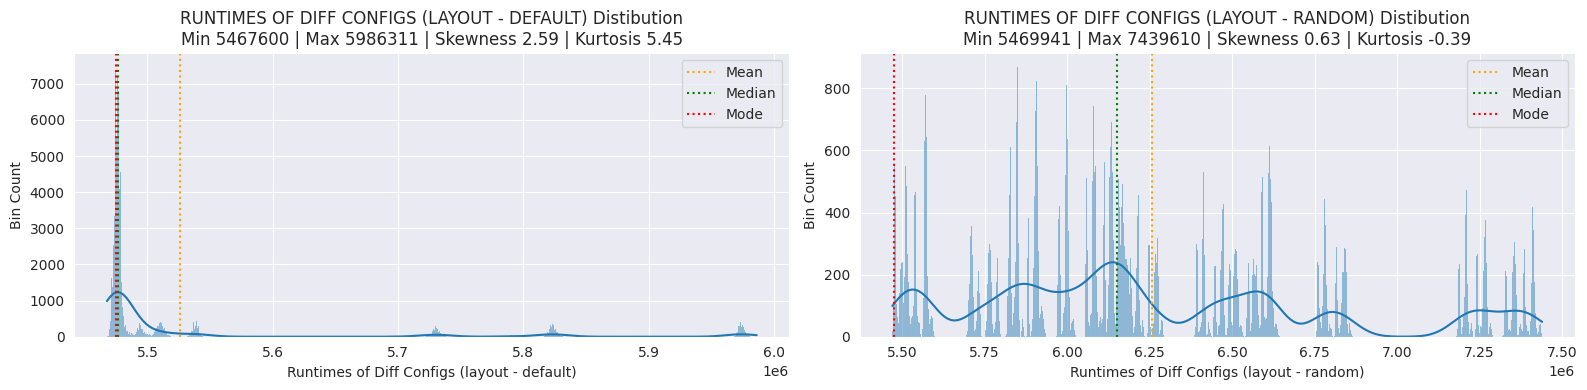

In [13]:
layout_demo2 = dict(np.load(DATA_ROOT/"layout/nlp/random/train/albert_en_base_batch_size_16_test.npz"))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
_plot_univar_dist(layout_demo["config_runtime"], "Runtimes of Diff Configs (layout - default)", 1000, ax=axes[0])
_plot_univar_dist(layout_demo2["config_runtime"], "Runtimes of Diff Configs (layout - random)", 1000, ax=axes[1])
plt.tight_layout()

#### g. `node_splits`
`node_splits` provides the information about the starting of HLO computations in the graph, which is beneficial to graph segmentations. Nodes `layout_tmp["node_splits"][i]` to `layout_tmp["node_splits"][i+1] - 1` belongs to the same computation.

In the demo examples, nodes `0` to `1095` belong to the same computation. That is, the entire graph belongs to the same computation.

In [14]:
print(f"The splitting point of the demo layout is {layout_demo['node_splits']}.")

The splitting point of the demo layout is [[   0 1696]].


<a id="kernel_lv"></a>
### *Kernel-Level Optimizations*
[**<span style="color:#FEF1FE; background-color:#535d70;border-radius: 5px; padding: 2px">Go to Table of Content</span>**](#toc)

[![Screenshot-2023-09-03-at-19-12-38-Google.png](https://i.postimg.cc/9QDZDp35/Screenshot-2023-09-03-at-19-12-38-Google.png)](https://postimg.cc/mPGtq728)
> Kernel-level optimizations can be done independently within each kernel.

At this level, a **kernel** (represented as a **fused subgraph**) is a fusion of multiple tensor oprations (*i.e.,* nodes in the computational graph). Kernels are optimized one at a time, independent of all the others. In this competition, **tile size selection** is our target compiler optimization.

>  *Tile* configuration controls the tile size of each fused subgraph

Just as `layout`, there are also many fields to be explored in `tile`. Furthermore, there exist many common fields. However, the `config`-related fields look a little bit different. Let's see what's going on.

In [15]:
tile_demo = dict(np.load(DATA_ROOT/"tile/xla/train/alexnet_train_batch_32_-1bae27a41d70f4dc.npz"))
for k, v in tile_demo.items():
    print(f"{k:<27}", f"| Type: {type(v)} | Dtype: {str(v.dtype):<8} | Shape {v.shape}")

node_feat                   | Type: <class 'numpy.ndarray'> | Dtype: float32  | Shape (12, 140)
node_opcode                 | Type: <class 'numpy.ndarray'> | Dtype: uint8    | Shape (12,)
edge_index                  | Type: <class 'numpy.ndarray'> | Dtype: int64    | Shape (11, 2)
config_feat                 | Type: <class 'numpy.ndarray'> | Dtype: float32  | Shape (266, 24)
config_runtime              | Type: <class 'numpy.ndarray'> | Dtype: int64    | Shape (266,)
config_runtime_normalizers  | Type: <class 'numpy.ndarray'> | Dtype: int64    | Shape (266,)


First, the quick checkings show that `tile` also follows the statement in the [data tab](https://www.kaggle.com/competitions/predict-ai-model-runtime/data); that is, the column 1 of `node_feat` is deprecated. Also, the alignment of op-codes is fine.

In [16]:
# data_checker_tile = DataChecker("tile")
# npz_illeg_tile = data_checker_tile.check()

In [17]:
# tile_with_nonzero_col1 = npz_illeg_tile["col1_deprecated"]
# tile_with_unaligned_ops = npz_illeg_tile["op_align"]
# print(f"There are {len(tile_with_nonzero_col1)} tiles whose column 1 of node_feat has non-zeros.")
# print(f"There are {len(tile_with_unaligned_ops)} tiles with unaligned op-codes.")

As state in the [data tab](https://www.kaggle.com/competitions/predict-ai-model-runtime/data),

> Crucially, the configuration is at the graph-level.

We already know that **tile size selection** is done as **kernel-level optimization**. Hence, the description actually means that the `tile` configuration is a configuration for the **entired fused subgraph**, which is different from the **per-node** manner in **graph-level optimization**.

#### a. `config_feat`
`config_feat` is a `(c, 24)` array, each row of which is the **(sub)graph-level** configuration feature vector. Each feature field has its own meaning, which can be found in the [data tab](https://www.kaggle.com/competitions/predict-ai-model-runtime/data).

Following is a quick illustration of the `j`-th configuration feature vector, where we take `j == 0`.

In [18]:
for k, v in tile_demo.items():
    print(f"{k:<27}", f"| Type: {type(v)} | Dtype: {str(v.dtype):<8} | Shape {v.shape}")

node_feat                   | Type: <class 'numpy.ndarray'> | Dtype: float32  | Shape (12, 140)
node_opcode                 | Type: <class 'numpy.ndarray'> | Dtype: uint8    | Shape (12,)
edge_index                  | Type: <class 'numpy.ndarray'> | Dtype: int64    | Shape (11, 2)
config_feat                 | Type: <class 'numpy.ndarray'> | Dtype: float32  | Shape (266, 24)
config_runtime              | Type: <class 'numpy.ndarray'> | Dtype: int64    | Shape (266,)
config_runtime_normalizers  | Type: <class 'numpy.ndarray'> | Dtype: int64    | Shape (266,)


In [19]:
c = tile_demo["config_feat"].shape[0]
for j in (0, 1, 2):
    config_feat_demo = tile_demo["config_feat"][j]
    config_runtime_demo = tile_demo["config_runtime"][j]
    config_runtime_normalizers_demo = tile_demo["config_runtime_normalizers"][j]

    print("-"*80)
    print(f"There are {c} different configurations for this fused subgraph (kernel).")
    print(f"The {j}-th configuration feature vector is:")
    print(config_feat_demo.astype(np.int32))
    print(config_runtime_demo)
    print(config_runtime_normalizers_demo)

--------------------------------------------------------------------------------
There are 266 different configurations for this fused subgraph (kernel).
The 0-th configuration feature vector is:
[  32   32    0    0    0    0   64 1024    4    2    0    0    0    0
    6    8    0    0    0    0    0    0    0    0]
263238
263238
--------------------------------------------------------------------------------
There are 266 different configurations for this fused subgraph (kernel).
The 1-th configuration feature vector is:
[32  1  0  0  0  0 33 32  1  2  0  0  0  0  3  2  0  0  0  0  0  0  0  0]
2029255
263238
--------------------------------------------------------------------------------
There are 266 different configurations for this fused subgraph (kernel).
The 2-th configuration feature vector is:
[16  4  0  0  0  0 20 64  1  1  0  0  0  0  2  1  0  0  0  0  0  0  0  0]
1192602
263238


#### b. `config_runtime` & `config_runtime_normalizers`
`config_runtime` and `config_runtime_normalizers` are both `(c, )` target arrays, where the former represents the runtime of the graphs compiled with the corresponding configurations and the latter with the **default** configuration. Slightly different from `layout`, we need to retrieve the configurations with the smallest `tile_tmp["config_runtime"] / tile_tmp["config_runtime_normalizers"]`, indicating the real runtime compared with the default setting (in the denominator). 

Following shows the distribution of `config_runtime` and runtime ratio of the demo example. Though they look the same in this example, it's possible to observe the difference between the two. And, the reason behind the scene is stated in the [data tab](https://www.kaggle.com/competitions/predict-ai-model-runtime/data),

> Samples from the same graph may have slightly different `"config_runtime_normalizers"` because they are measured from different runs on multiple machines.

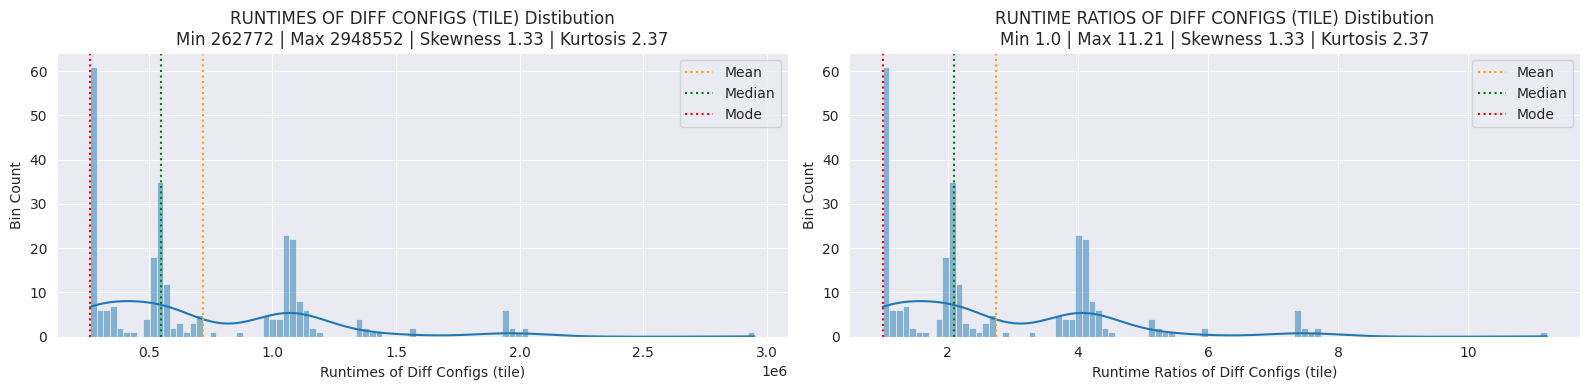

In [20]:
ratio = tile_demo["config_runtime"] / tile_demo["config_runtime_normalizers"]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
_plot_univar_dist(tile_demo["config_runtime"], "Runtimes of Diff Configs (tile)", 100, ax=axes[0])
_plot_univar_dist(ratio, "Runtime Ratios of Diff Configs (tile)", 100, ax=axes[1])
plt.tight_layout()

<a id="graph_stats"></a>
## 3. Basic Graph Statistics
[**<span style="color:#FEF1FE; background-color:#535d70;border-radius: 5px; padding: 2px">Go to Table of Content</span>**](#toc)

To better understand the properties of computational graphs in hand, let's derive basic graph statistics in a **collection-specific** manner. Then, we can compare if there exists different characteristic among collections. More stats can be derived if you're interested.

Currently implemented statistics are listed as follows:
1. `n_nodes`: Number of nodes in the computational graph, indicating how many **tensor oprations** are performed.
2. `n_edges`: Number of edges in the computational graph, indicating the total number of **tensor flows**.
3. `avg_deg`: Average degree of the computational graph, which is defined as,
$$
    avg\_deg = \frac{1}{n} (\sum_{i}^{n} in\_deg_i + \sum_{i}^{n} out\_deg_i)
$$
, where $n$ is the total number of nodes, $in\_deg_i$ and $out\_deg_i$ are in-degree and out-degree of node $i$.
4. `avg_clust_coeff`: Average clustering coefficient of the computational graph, which is defined as a proportion of the number of **directed triangles** through the anchor node $u$ divided by the number of **possible links** within $u$'s neighbourhood.
    * For implementation, please see the source code [here](https://networkx.org/documentation/stable/_modules/networkx/algorithms/cluster.html#average_clustering).
5. `longest_path`: The longest path in the computational graph, indicating how deep the model architecture is.

Following illustrates what is the **directed triangles**. For each node acting as an anchor (take `conv` as an example), 2 directed triangles can be formed from the perspective of its two neighbors (*e.g.,* `reshape` and `add`). Finding different directed polygons (*e.g.,* rectangle) can somewhat help us better understand the model architecture (*e.g.,*  residual links).

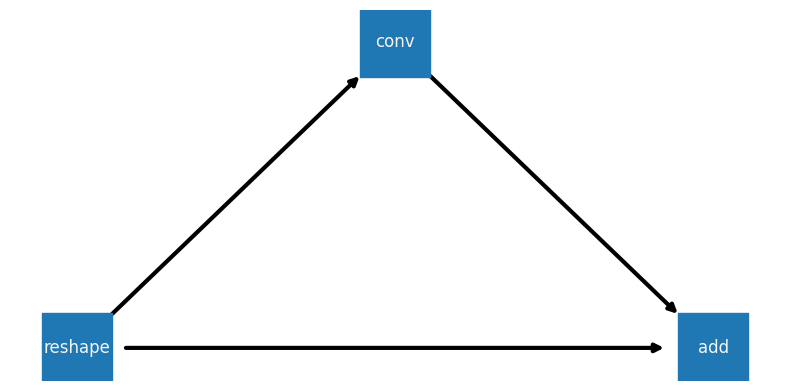

In [21]:
edge_list = [(0, 1), (1, 2), (0, 2)]
g = nx.DiGraph(edge_list)

fig, ax = plt.subplots(figsize=(8, 4))
options = {
    "node_color": "tab:blue",
    'node_size': 2500,
    "node_shape": "s",
    "width": 3,
    "arrowstyle": "-|>",
    "arrowsize": 12,
}
pos = {0: [0.2, 0.2], 1: [0.5, 0.5], 2: [0.8, 0.2]}
labels = {0: "reshape", 1: "conv", 2: "add"}
nx.draw_networkx(g, with_labels=False, pos=pos, ax=ax, arrows=True, **options)
nx.draw_networkx_labels(g, pos, labels, ax=ax, font_size=12, font_color="whitesmoke")
plt.tight_layout()
plt.axis("off")
plt.show()

In [22]:
class GraphStatsEngineer(object):
    """Derive basic statistics of graphs from different collections.

    Parameters:
        coll: collection
            *Note: Run all collections if not given
        debug: if False, sanity checks are ignored
    """

    def __init__(self, coll: Optional[str] = None, debug: bool = False) -> None:
        self.coll = [coll] if coll is not None else COLL
        self.debug = debug

    def run(self, stats_list: List[str] = ["n_nodes"]) -> Tuple[Dict[str, Any], List[str]]:
        """Derive the graph stats.
        
        Parameters:
            stats_list: graph stats, the choices are as follows:
                {"n_nodes", "n_edges", "avg_deg", "avg_clust_coeff", "longest_path"}

        Return:
            stats: graph statistics
            npz_illeg: .npz files failing sanity checks
        """
        stats = {}
        npz_illeg = []
        
        for coll in self.coll:
            stats[coll] = {"split": [], "file": [], "n_graphs": 0}
            for s in stats_list:
                stats[coll][s] = []
            coll_root = _get_coll_root(coll)
            
            for split in SPLIT:
                data_root = coll_root/split
                for file in tqdm(os.listdir(data_root)):
                    if file.endswith(".npz"):
                        stats[coll]["split"].append(split)
                        stats[coll]["file"].append(file)
                        stats[coll]["n_graphs"] += 1
                    else:
                        continue
                    
                    # Prepare data
                    npz_tmp = self._load_npz(data_root/file)
                    g_tmp = self._get_digraph(npz_tmp["edge_index"])
    
                    # Derive stats
                    stats_tmp = self._run_single(npz_tmp, g_tmp, stats_list)
                    if stats_tmp is not None:
                        for s, v in stats_tmp.items():
                            stats[coll][s].append(v)
                    else:
                        npz_illeg.append(str(data_root/file))
                        
        return stats, npz_illeg

    def _load_npz(self, data_file: Path) -> Dict[str, np.ndarray]:
        """Load and return the graph with its configurations.

        Parameters:
            data_file: path to data

        Return:
            npz_tmp: graph and configurations
        """
        npz_tmp = dict(np.load(data_file))

        return npz_tmp
    
    def _get_digraph(self, edge_index: np.ndarray) -> nx.DiGraph:
        """Return the NetworkX Graph.

        Parameters:
            edge_index: edge index

        Return:
            digraph: directed graph representation of the computational
                graph
        """
        edge_list = list(map(tuple, edge_index))
        digraph = nx.DiGraph(edge_list)

        return digraph
    
    def _run_single(
        self,
        npz: Dict[str, np.ndarray],
        g: nx.DiGraph,
        stats_list: List[str]
    ) -> Optional[Dict[str, float]]:
        """Derive the graph stats for a single graph.
        
        Parameters:
            npz: graph and configurations
            g: directed graph representation of the computational graph
            stats: graph stats

        Return:
            stats_single: graph stats of the current graph
        """
        stats_single = {}
        if "n_nodes" in stats_list:
            n_nodes = g.order()
            if self.debug and n_nodes != len(npz["node_feat"]):
                return None
            stats_single["n_nodes"] = n_nodes
        if "n_edges" in stats_list:
            n_edges = g.size()
            if self.debug and n_edges != len(npz["edge_index"]):
                return None
            stats_single["n_edges"] = n_edges
        if "avg_deg" in stats_list:
            n_nodes = g.order()  # Note if any orphan node
            avg_deg = sum(dict(g.degree).values()) / n_nodes
            avg_indeg = sum(dict(g.in_degree).values()) / n_nodes
            avg_outdeg = sum(dict(g.out_degree).values()) / n_nodes
            if self.debug and avg_deg != avg_indeg + avg_outdeg:
                return None
            stats_single["avg_deg"] = avg_deg
        if "avg_clust_coeff" in stats_list:
            avg_clust_coeff = nx.average_clustering(g)
            stats_single["avg_clust_coeff"] = avg_clust_coeff
        if "longest_path" in stats_list:
            longest_path = nx.dag_longest_path_length(g)
            stats_single["longest_path"] = longest_path

        return stats_single

In [23]:
eng = GraphStatsEngineer(debug=False)
stats_list = ["n_nodes", "n_edges", "avg_deg", "avg_clust_coeff", "longest_path"]
stats, _ = eng.run(stats_list)

  0%|          | 0/198 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/207 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/5709 [00:00<?, ?it/s]

  0%|          | 0/676 [00:00<?, ?it/s]

  0%|          | 0/844 [00:00<?, ?it/s]

After comparing graph statistics in different collections, some observations are summarized as follows:
1. For optimization `layout`, distributions of stats `avg_deg` and `avg_clust_coeff` of source `xla` are more different for different search strategies than source `nlp`.
2. There exist much deeper model architectures in `layout-xla` compared with `layout-nlp`.
3. `tile-xla` shows the most distinct characteristics.
    * It has the most number of graphs compared with the others.
    * Graphs have much less number of nodes and edges.
    * Longest paths are much shorter.

Point 3 is reasonable, because graphs in `tile-xla` are **fused subgraphs**, which are intrinsically smaller than the entire graph.

<a id="lnd"></a>
### *`layout-nlp-default`*
[**<span style="color:#FEF1FE; background-color:#535d70;border-radius: 5px; padding: 2px">Go to Table of Content</span>**](#toc)

There are 235 graphs in collection layout-nlp-default.


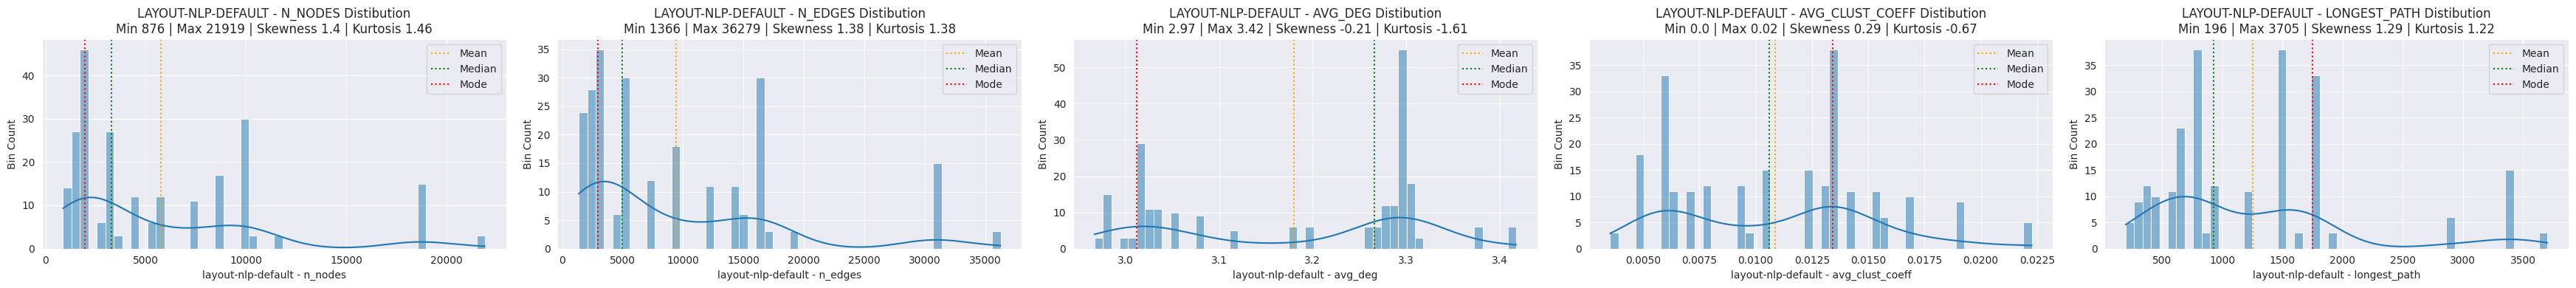

In [24]:
coll = "layout-nlp-default"

print(f"There are {stats[coll]['n_graphs']} graphs in collection {coll}.")
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(35, 4))
for i, s in enumerate(stats_list):
    _plot_univar_dist(np.array(stats[coll][s]), f"{coll} - {s}", 50, ax=axes[i])
plt.tight_layout()

<a id="lnr"></a>
### *`layout-nlp-random`*
[**<span style="color:#FEF1FE; background-color:#535d70;border-radius: 5px; padding: 2px">Go to Table of Content</span>**](#toc)

There are 244 graphs in collection layout-nlp-random.


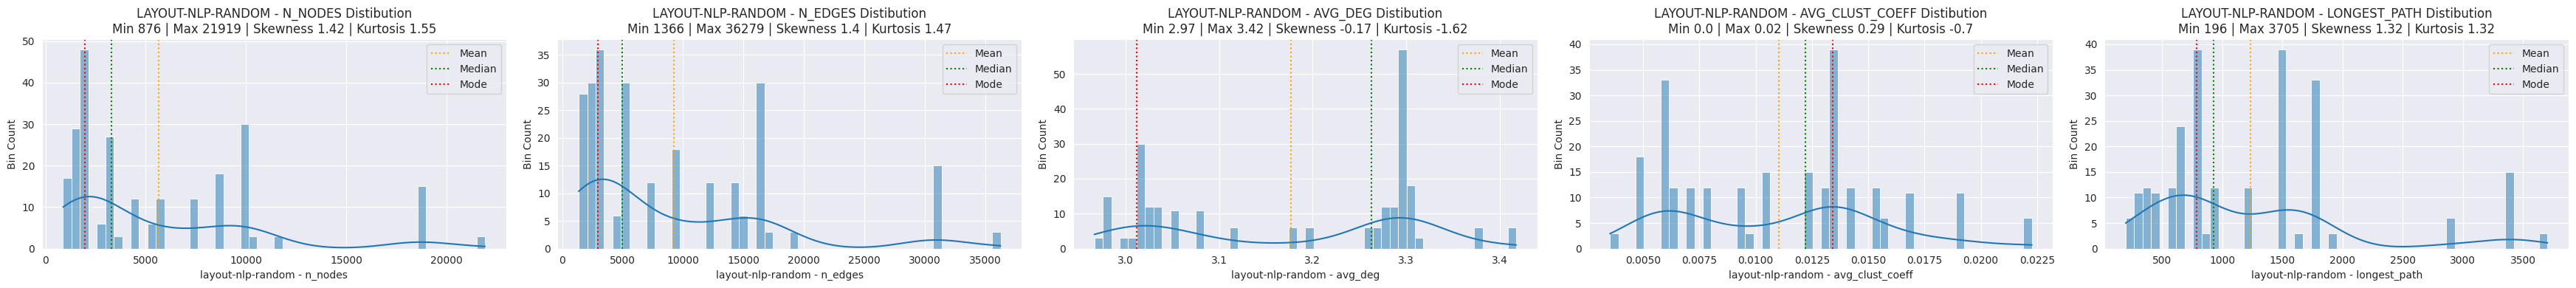

In [25]:
coll = "layout-nlp-random"

print(f"There are {stats[coll]['n_graphs']} graphs in collection {coll}.")
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(35, 4))
for i, s in enumerate(stats_list):
    _plot_univar_dist(np.array(stats[coll][s]), f"{coll} - {s}", 50, ax=axes[i])
plt.tight_layout()

<a id="lxd"></a>
### *`layout-xla-default`*
[**<span style="color:#FEF1FE; background-color:#535d70;border-radius: 5px; padding: 2px">Go to Table of Content</span>**](#toc)

There are 76 graphs in collection layout-xla-default.


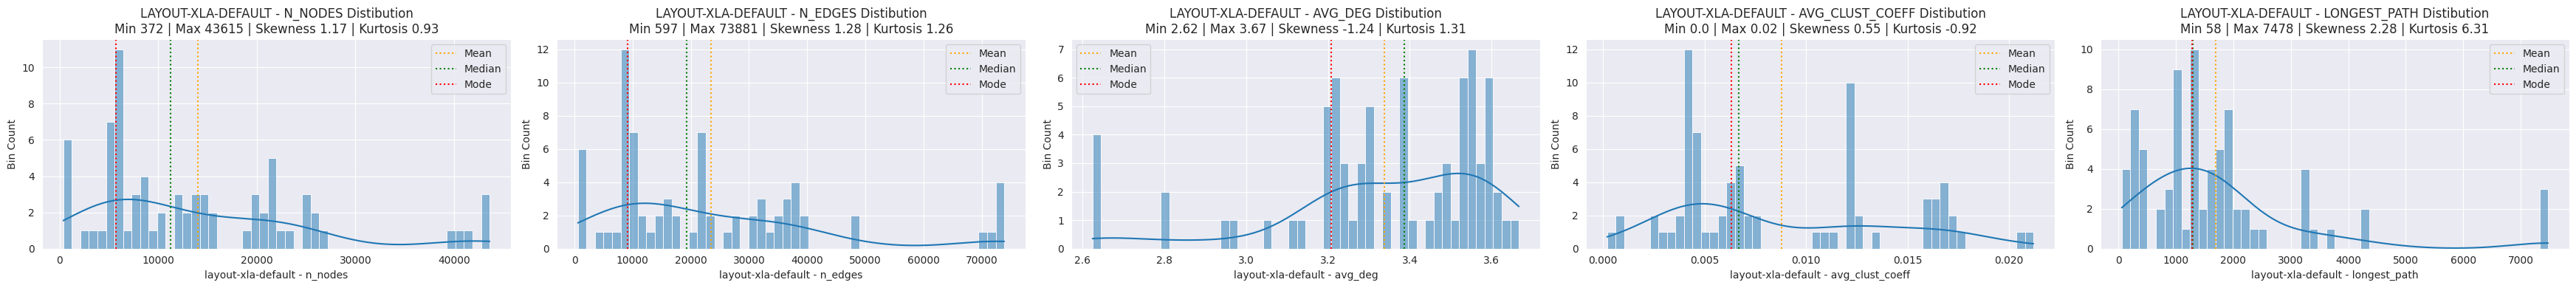

In [26]:
coll = "layout-xla-default"

print(f"There are {stats[coll]['n_graphs']} graphs in collection {coll}.")
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(35, 4))
for i, s in enumerate(stats_list):
    _plot_univar_dist(np.array(stats[coll][s]), f"{coll} - {s}", 50, ax=axes[i])
plt.tight_layout()

<a id="lxr"></a>
### *`layout-xla-random`*
[**<span style="color:#FEF1FE; background-color:#535d70;border-radius: 5px; padding: 2px">Go to Table of Content</span>**](#toc)

There are 84 graphs in collection layout-xla-random.


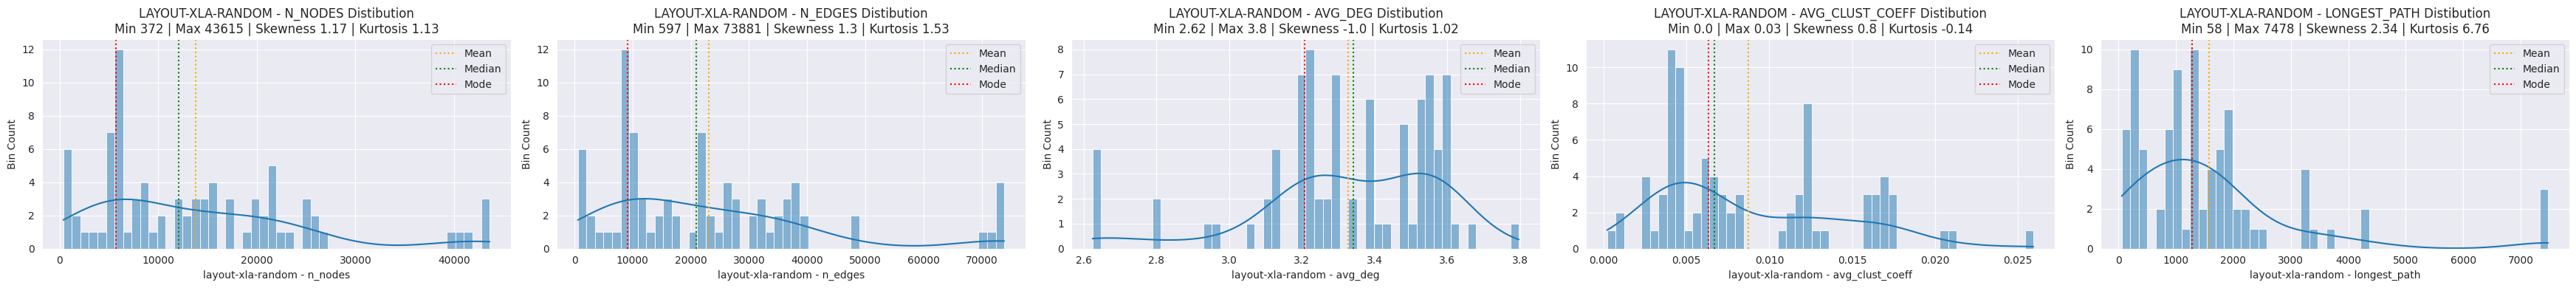

In [27]:
coll = "layout-xla-random"

print(f"There are {stats[coll]['n_graphs']} graphs in collection {coll}.")
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(35, 4))
for i, s in enumerate(stats_list):
    _plot_univar_dist(np.array(stats[coll][s]), f"{coll} - {s}", 50, ax=axes[i])
plt.tight_layout()

<a id="tx"></a>
### *`tile-xla`*
[**<span style="color:#FEF1FE; background-color:#535d70;border-radius: 5px; padding: 2px">Go to Table of Content</span>**](#toc)

There are 7229 graphs in collection tile-xla.


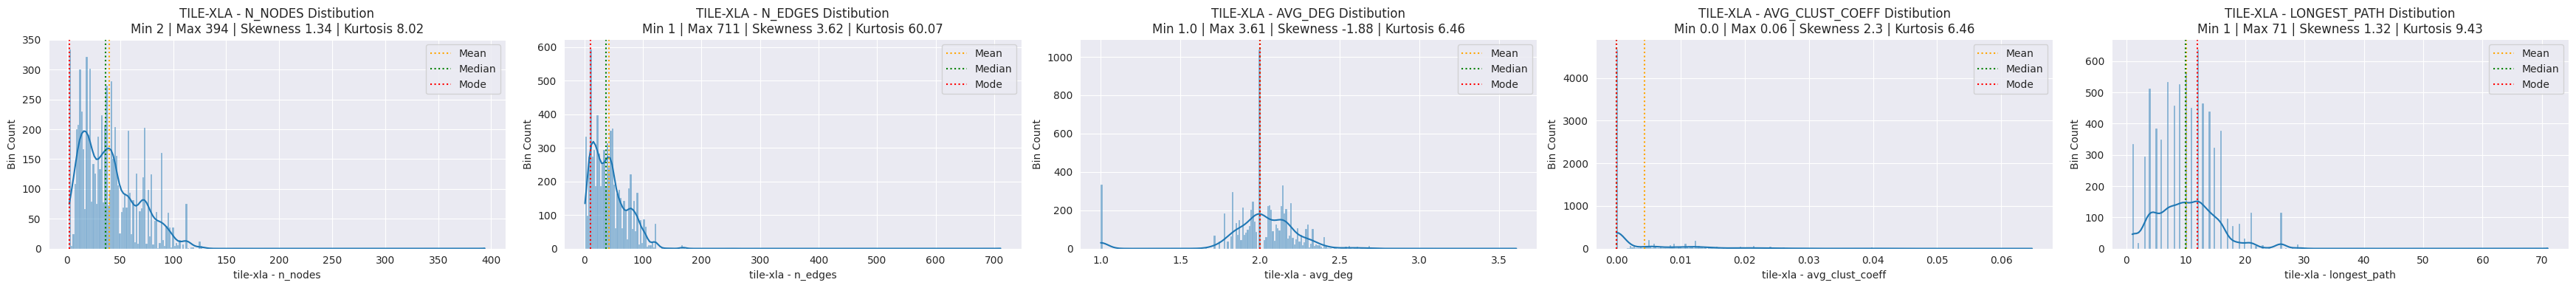

In [28]:
coll = "tile-xla"

print(f"There are {stats[coll]['n_graphs']} graphs in collection {coll}.")
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(35, 4))
for i, s in enumerate(stats_list):
    _plot_univar_dist(np.array(stats[coll][s]), f"{coll} - {s}", 250, ax=axes[i])
plt.tight_layout()

There exist some files failing the sanity checks in stats engineering process (please set `debug` to `True` if you want to explore further). After analysis, they all fail the check of `n_nodes == len(npz["node_feat"])`. The reason behind the scene is that I use `edge_index` to construct the `DiGraph`. Hence, isolated nodes aren't taken into consideration.

<div class="alert alert-block alert-warning">
    <h5>But, what does an isolated node mean in the computational graph?</h5>
</div>
<div class="alert alert-block alert-danger">
    <h5>The meaning of isolated nodes in a computational graph has been explained by the host <a href="https://www.kaggle.com/competitions/predict-ai-model-runtime/discussion/437068#2425354">here</a>. Also, I've confirmed that all isolated nodes in the raw data are <b>parameter</b> (with op-code 63).</h5>
</div>

In [29]:
# for data_file in npz_illeg:
#     print(f"File {data_file}")
#     npz_tmp = dict(np.load(data_file))
#     g_tmp = nx.DiGraph(list(map(tuple, npz_tmp["edge_index"])))

#     iso_nodes = set(np.arange(len(npz_tmp["node_feat"]))).difference(set(g_tmp.nodes()))
#     print(f"-> Isolated nodes: {iso_nodes}")

#     # Check op-codes of isolated nodes
#     iso_op_codes = npz_tmp["node_opcode"][list(iso_nodes)]
#     iso_op_codes_uniq = np.unique(iso_op_codes)
#     assert len(iso_op_codes_uniq) == 1 and iso_op_codes_uniq[0] == 63

Let's convert graph stats to `DataFrame` and dump it `.csv` file for quicker access in the future.

In [30]:
df = []
for coll, stats_ in stats.items():
    df_coll = pd.DataFrame.from_dict(stats_)
    df_coll["coll"] = coll
    df.append(df_coll)
df = pd.concat(df, ignore_index=True)
df = df[[df.columns[-1]] + [c for c in df.columns[:-1]]]
_summarize(df, "Graph Stats", 2)
df.to_csv("graph_stats.csv", index=False)

=====Summary of Graph Stats=====


,coll,split,file,n_graphs,n_nodes,n_edges,avg_deg,avg_clust_coeff,longest_path
0,layout-nlp-default,train,small_bert_bert_en_uncased_L-2_H-768_A-12_batc...,235,876,1366,3.118721,0.022272,196
1,layout-nlp-default,train,bert_en_uncased_L-12_H-768_A-12_batch_size_32_...,235,1976,2976,3.012146,0.013414,786


Shape: (7868, 9)
NaN ratio:


,coll,split,file,n_graphs,n_nodes,n_edges,avg_deg,avg_clust_coeff,longest_path
NaN Ratio,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Zero ratio:


,avg_clust_coeff,coll,split,file,n_graphs,n_nodes,n_edges,avg_deg,longest_path
Zero Ratio,59.379766,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<a id="runtime"></a>
## 4. Our Target - Runtime
[**<span style="color:#FEF1FE; background-color:#535d70;border-radius: 5px; padding: 2px">Go to Table of Content</span>**](#toc)

In this competition, our goal is to predict the runtime of graphs and configurations (*i.e.,* execution time of the graph compiled with the specific configuration). Hence, let's move on to the main focus, `config_time`, to get familiar with it! 

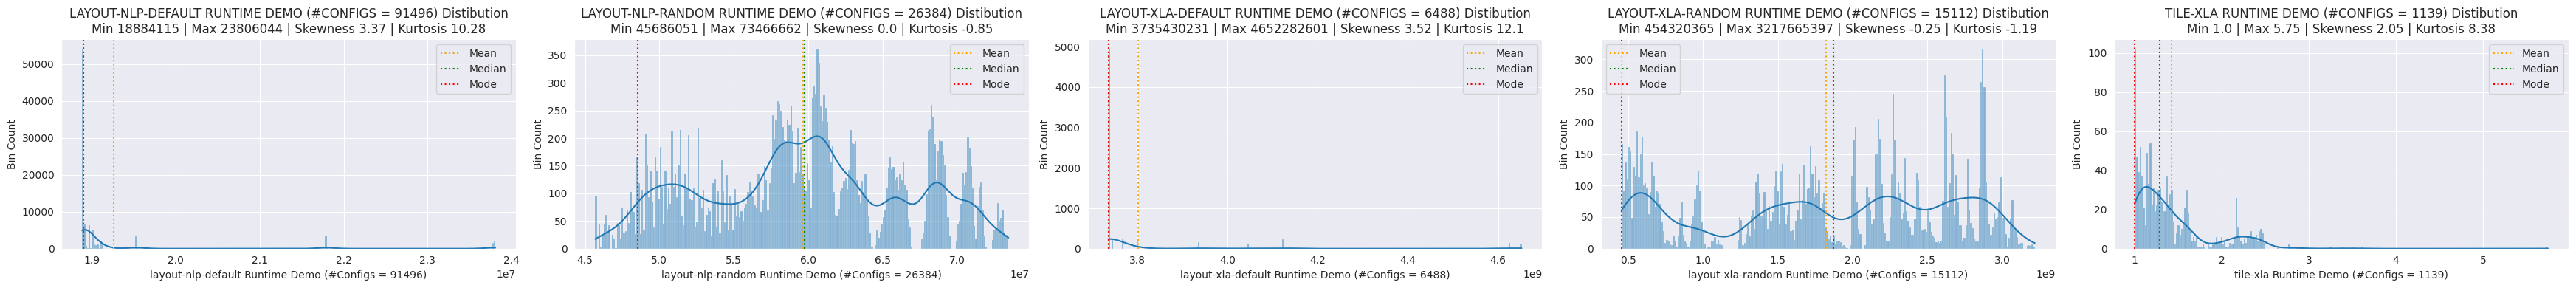

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=len(COLL), figsize=(35, 4))
for i, coll in enumerate(COLL):
    coll_root_tr = _get_coll_root(coll)/"train"
    data_files = os.listdir(coll_root_tr)
    data_file = coll_root_tr/data_files[random.randint(0, len(data_files))]
    npz_tmp = dict(np.load(data_file))

    n_configs = len(npz_tmp["config_runtime"])
    if coll != "tile-xla":
        runtime = npz_tmp["config_runtime"]
    else:
        runtime = npz_tmp["config_runtime"] / npz_tmp["config_runtime_normalizers"]
    _plot_univar_dist(runtime, f"{coll} Runtime Demo (#Configs = {n_configs})", ax=axes[i])
plt.tight_layout()

To analyze runtime behavior, we first derive runtime stats with the way similar to graph stats derivation. Then, we'll combine graph stats with runtime stats to do some comparisons.

In [32]:
def _get_runtime_stats(runtime: np.ndarray) -> Dict[str, float]:
    """Derive and return runtime stats of one computational graph.

    Parameters:
        runtime: runtime of different configs

    Return:
        runtime_stats: runtime stats of one graph
    """
    runtime_stats = {
        "runtime_mean": np.mean(runtime),
        "runtime_std": np.std(runtime),
        "runtime_min": np.min(runtime),
        "runtime_max": np.max(runtime),
        "runtime_median": np.median(runtime),
        "runtime_mode": mode(runtime),
        "runtime_skew": skew(runtime),
        "runtime_kurt": kurtosis(runtime)
    }

    return runtime_stats

In [33]:
runtime_stats_list = ["mean", "std", "min", "max",
                      "median", "mode", "skew", "kurt"]
target_stats = {}
for coll in COLL:
    target_stats[coll] = {"split": [], "file": [], "n_configs": []}
    for s in runtime_stats_list:
        target_stats[coll][f"runtime_{s}"] = []
    coll_root = _get_coll_root(coll)
    
    for split in SPLIT:
        data_root = coll_root/split
        for file in tqdm(os.listdir(data_root)):
            if not file.endswith(".npz"):
                continue

            npz_tmp = dict(np.load(data_root/file))
            target_stats[coll]["split"].append(split)
            target_stats[coll]["file"].append(file)
            target_stats[coll]["n_configs"].append(len(npz_tmp["config_runtime"]))
            
            # Derive runtime stats
            if coll != "tile-xla":
                runtime = npz_tmp["config_runtime"]
            else:
                runtime = npz_tmp["config_runtime"] / npz_tmp["config_runtime_normalizers"]
            runtime_stats = _get_runtime_stats(runtime)
            for s, v in runtime_stats.items():
                target_stats[coll][s].append(v)

  0%|          | 0/198 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/207 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/5709 [00:00<?, ?it/s]

  0%|          | 0/676 [00:00<?, ?it/s]

  0%|          | 0/844 [00:00<?, ?it/s]

Again, we dump runtime stats `DataFrame` for future access.

In [34]:
df_target = []
for coll, target_stats_ in target_stats.items():
    df_coll = pd.DataFrame.from_dict(target_stats_)
    df_coll["coll"] = coll
    df_target.append(df_coll)
df_target = pd.concat(df_target, ignore_index=True)
df_target = df_target[[df_target.columns[-1]] + [c for c in df_target.columns[:-1]]]
_summarize(df_target, "Runtime Stats", 2)
df_target.to_csv("runtime_stats.csv", index=False)

=====Summary of Runtime Stats=====


,coll,split,file,n_configs,runtime_mean,runtime_std,runtime_min,runtime_max,runtime_median,runtime_mode,runtime_skew,runtime_kurt
0,layout-nlp-default,train,small_bert_bert_en_uncased_L-2_H-768_A-12_batc...,100040,1.146219e+06,24008.817974,1129902.0,1241375.0,1135594.0,"(1134292, 120)",1.920094,2.018541
1,layout-nlp-default,train,bert_en_uncased_L-12_H-768_A-12_batch_size_32_...,100040,1.040667e+07,233701.126909,10291260.0,11295657.0,10303574.0,"(10303214, 42)",2.569786,6.007527


Shape: (7868, 12)
NaN ratio:


,runtime_skew,runtime_kurt,coll,split,file,n_configs,runtime_mean,runtime_std,runtime_min,runtime_max,runtime_median,runtime_mode
NaN Ratio,11.362481,11.362481,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Zero ratio:


,runtime_mean,runtime_std,runtime_min,runtime_max,runtime_median,runtime_skew,coll,split,file,n_configs,runtime_mode,runtime_kurt
Zero Ratio,11.362481,11.362481,11.362481,11.362481,11.362481,0.050839,0.0,0.0,0.0,0.0,0.0,0.0


Because we have no access to groundtruth of the test set, we keep only the training and validation sets for analysis. What's more, graphs in `layout` and `tile` are at different levels (*i.e.,* graph-level and kernel-level), having `config_runtime` at different scales. Hence, we'll analyze them separately.

In [35]:
df = df.merge(df_target, on=["coll", "split", "file"])  # Merge graph stats with runtime stats
df = df[df["split"] != "test"].reset_index(drop=True)
df_layout = df[df.coll.str.startswith("layout")].reset_index(drop=True)
df_tile = df[df.coll.str.startswith("tile")].reset_index(drop=True)
print(f"There are {len(df_layout)} graphs in layout and {len(df_tile)} in tile.")

There are 589 graphs in layout and 6385 in tile.


To observe runtime behavior w.r.t. graph stats, we select `runtime_mean` (*i.e.,* average runtime over all configurations) as the target. Also, we take `np.log1p` on `runtime_mean` for better visualization and interpretation.

In general, computational graphs with the following properties tend to run longer:
1. Have more nodes.
    * More tensor operations to run.
2. Have more edges.
    * More tensor flows to pass.
3. With greater average degrees.
    * Probably more complex connetion in network.
4. With longer path.
    * Probabaly deeper network.

In [36]:
df_layout["runtime_mean_log"] = np.log1p(df_layout.runtime_mean)
df_tile["runtime_mean_log"] = np.log1p(df_tile.runtime_mean)

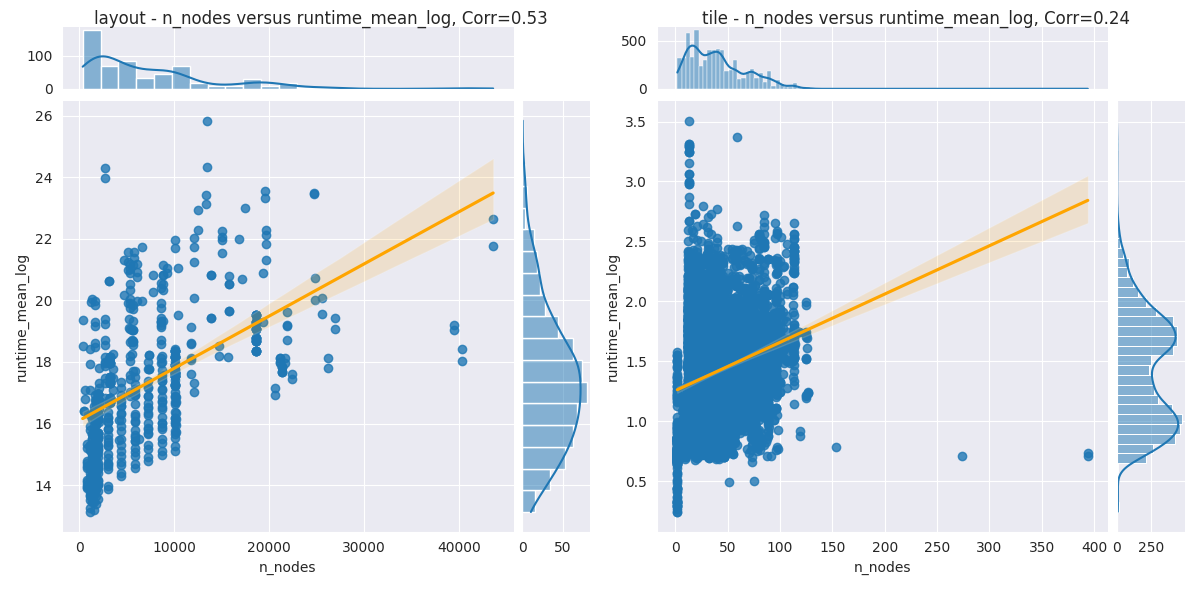

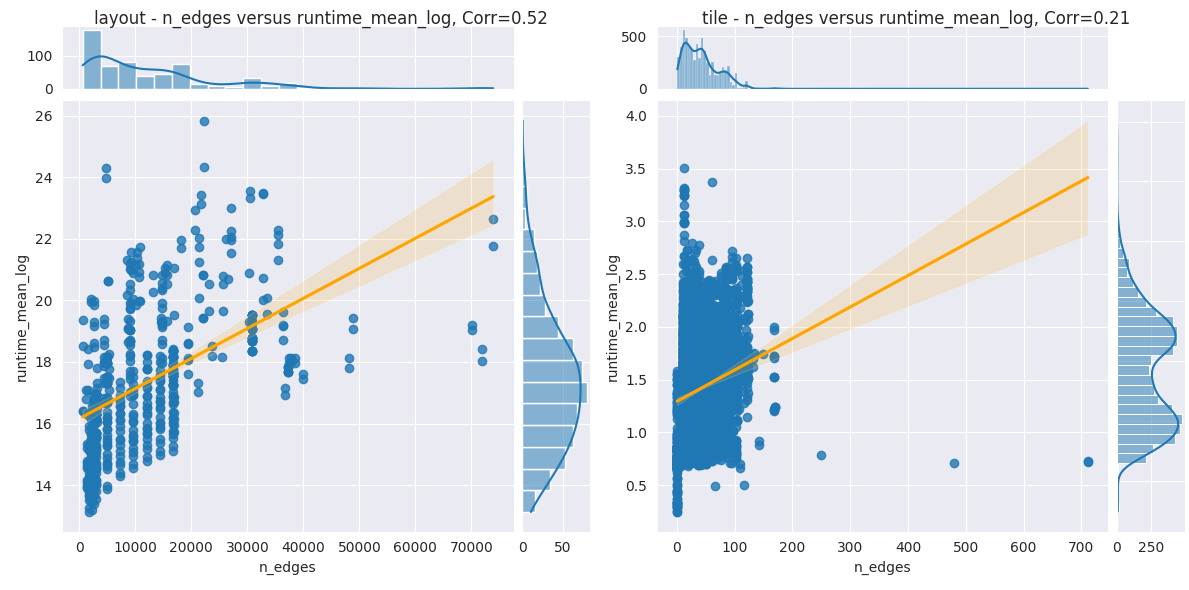

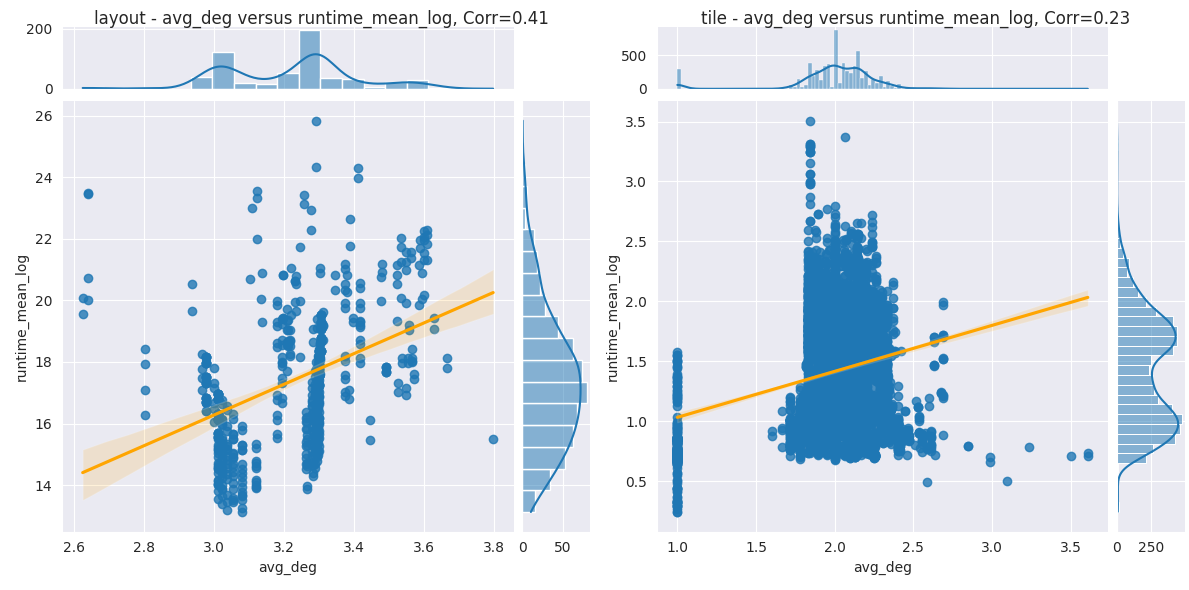

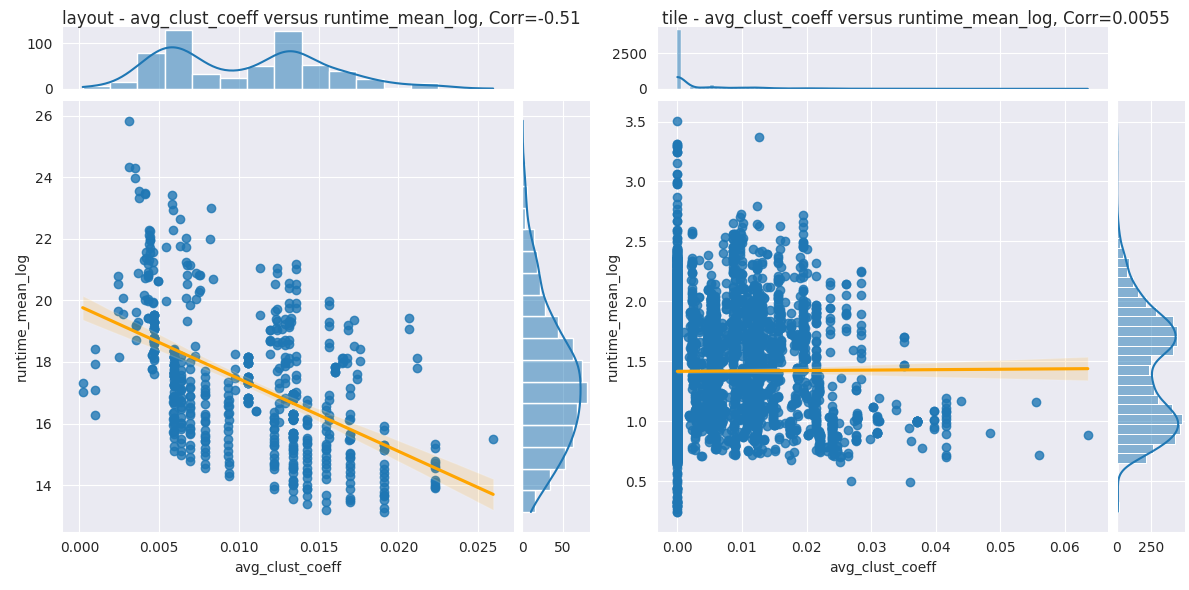

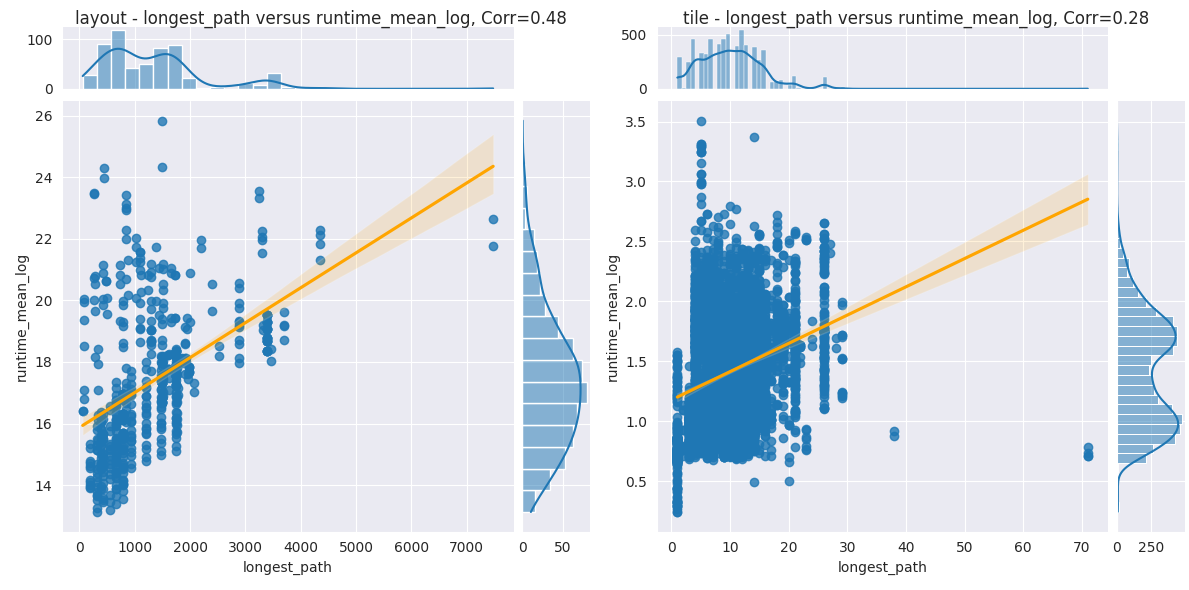

In [37]:
for s in stats_list:
    fig = plt.figure(figsize=(12, 6))
    gs = gridspec.GridSpec(1, 2)
    for i, (optim, df_) in enumerate(zip(OPTIM, [df_layout, df_tile])):
        jg, title = _plot_bivar(df_, [s, "runtime_mean_log"])
        _ = SeabornFig2Grid(jg, fig, gs[i])

        # Add title
        ax_ghost = fig.add_subplot(gs[i])
        ax_ghost.axis("off")
        ax_ghost.set_title(f"{optim} - {title}")
    plt.tight_layout()

Same as what we observe in the plots above, the correlation heatmap shows that graph stats, excluding `avg_clust_coeff`, generally have positive correlation with average runtime. Also, strong positive correlations exist between multiple graph stats pairs.

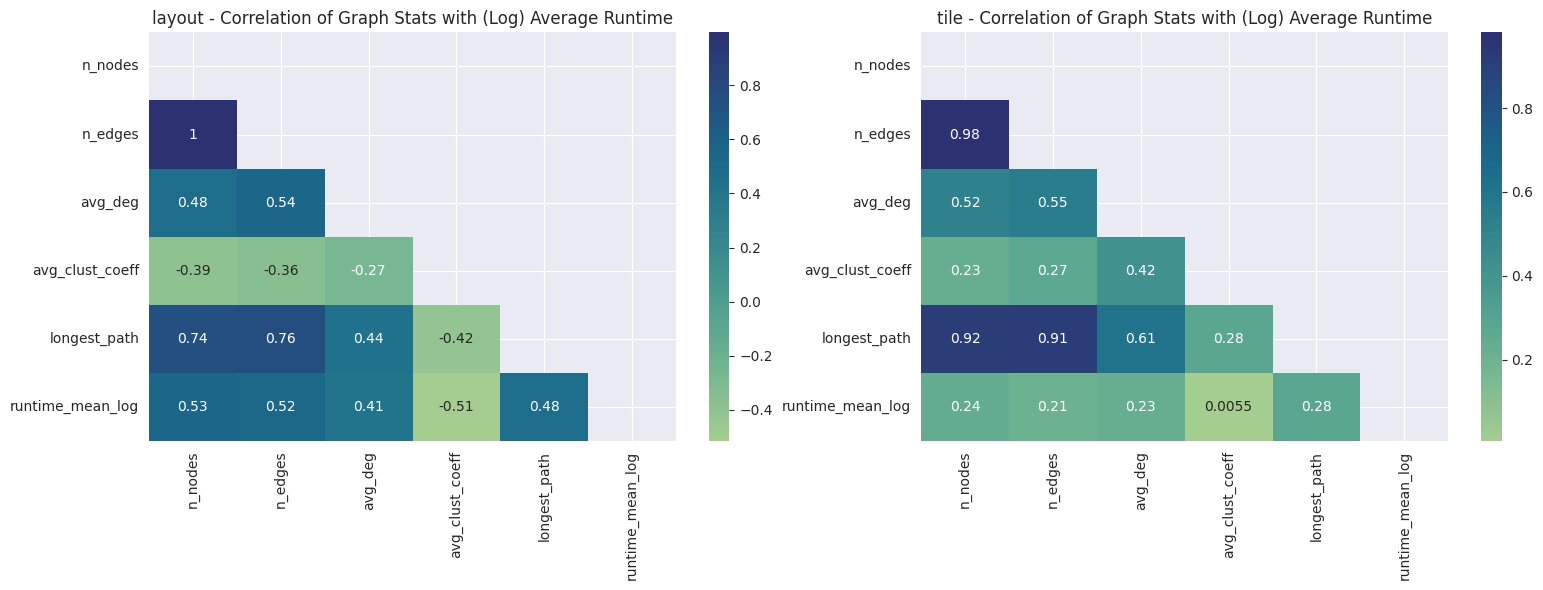

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
for i, (optim, df_) in enumerate(zip(OPTIM, [df_layout, df_tile])):
    df_corr = df_[stats_list + ["runtime_mean_log"]].corr()
    mask = np.triu(np.ones_like(df_corr, dtype=np.bool_))
    sns.heatmap(df_corr, mask=mask, cmap="crest", annot=True, ax=axes[i])
    axes[i].set_title(f"{optim} - Correlation of Graph Stats with (Log) Average Runtime")
    plt.tight_layout()

<a id="ref"></a>
## Reference
[**<span style="color:#FEF1FE; background-color:#535d70;border-radius: 5px; padding: 2px">Go to Table of Content</span>**](#toc)

[1] [TpuGraphs: A Performance Prediction Dataset on Large Tensor Computational Graphs](https://arxiv.org/pdf/2308.13490.pdf)<br>
[2] [Topological sorting](https://en.wikipedia.org/wiki/Topological_sorting)

Thanks for your attention, please stay tuned to see more analysis and explanations!